In [1]:
import pandas as pd    # pyright: ignore[reportMissingImports]
import numpy as np  # pyright: ignore[reportMissingImports]
from datasets import load_dataset  # pyright: ignore[reportMissingImports]
import matplotlib.pyplot as plt  # pyright: ignore[reportMissingImports]
import seaborn as sns  # pyright: ignore[reportMissingModuleSource]
from collections import Counter
from dataclasses import dataclass
from typing import Optional, Tuple
import torchvision.transforms as T  # pyright: ignore[reportMissingImports]
import random


C:\Users\abdul\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Analyze the food ingredients dataset to understand its structure and unique values.
print("Loading dataset...")
ds = load_dataset("Scuccorese/food-ingredients-dataset")

Loading dataset...


In [3]:
print("Dataset structure:")
print(f"Number of examples: {len(ds['train'])}")
print(f"Features: {ds['train'].features}")
    
    # Get unique values for each feature
print("\n=== UNIQUE VALUES ANALYSIS ===")
print(f"Unique categories: {len(set(ds['train']['category']))}")
print(f"Unique subcategories: {len(set(ds['train']['subcategory']))}")
print(f"Unique ingredients: {len(set(ds['train']['ingredient']))}")

Dataset structure:
Number of examples: 6676
Features: {'category': Value('string'), 'subcategory': Value('string'), 'ingredient': Value('string'), 'image': Image(mode=None, decode=True)}

=== UNIQUE VALUES ANALYSIS ===
Unique categories: 12
Unique subcategories: 28
Unique ingredients: 316


In [4]:
print("\n=== CATEGORIES ===")
categories = list(set(ds['train']['category']))
print(f"Categories ({len(categories)}): {sorted(categories)}")


=== CATEGORIES ===
Categories (12): ['baking', 'canned', 'fruits', 'grains', 'jars', 'legumes', 'meats', 'oils', 'olives', 'packaged', 'pasta', 'vegetables']


In [5]:
ingredient_counts = Counter(ds['train']['ingredient'])
for ingredient, count in ingredient_counts.most_common():
        print(f"{ingredient}: {count} ({count/len(ds['train'])*100:.1f}%)")

mustard greens: 40 (0.6%)
watercress: 40 (0.6%)
kohlrabi: 40 (0.6%)
duck: 40 (0.6%)
pheasant: 40 (0.6%)
elk: 40 (0.6%)
caribou: 40 (0.6%)
mango: 40 (0.6%)
canned green beans: 40 (0.6%)
quinoa: 40 (0.6%)
all-purpose flour: 40 (0.6%)
bread flour: 40 (0.6%)
cake flour: 40 (0.6%)
self-rising flour: 40 (0.6%)
oat flour: 40 (0.6%)
gluten-free flour: 40 (0.6%)
coconut sugar: 40 (0.6%)
muscovado sugar: 40 (0.6%)
bok choy: 38 (0.6%)
wild boar: 38 (0.6%)
spelt: 38 (0.6%)
whole wheat flour: 38 (0.6%)
coconut flour: 38 (0.6%)
white sugar: 38 (0.6%)
powdered sugar: 38 (0.6%)
millet: 36 (0.5%)
rye flour: 36 (0.5%)
brown sugar: 36 (0.5%)
cane sugar: 36 (0.5%)
raw sugar: 36 (0.5%)
date sugar: 36 (0.5%)
almond flour: 34 (0.5%)
turbinado sugar: 34 (0.5%)
demerara sugar: 34 (0.5%)
kale: 20 (0.3%)
arugula: 20 (0.3%)
collard greens: 20 (0.3%)
romaine: 20 (0.3%)
radish: 20 (0.3%)
turnip: 20 (0.3%)
parsnip: 20 (0.3%)
broccoli: 20 (0.3%)
radicchio: 20 (0.3%)
garlic: 20 (0.3%)
shallot: 20 (0.3%)
spring onion: 

In [6]:
# Check image properties
print("\n=== IMAGE ANALYSIS ===")
image_sizes = []
for i in range(min(100, len(ds['train']))):  # Check first 100 images
    img = ds['train'][i]['image']
    image_sizes.append(img.size)

print(f"Sample image sizes: {set(image_sizes)}")
print(f"Most common image size: {Counter(image_sizes).most_common(1)[0]}")

# Check if all images are the same size
unique_sizes = set(image_sizes)
print(f"Number of unique image sizes in sample: {len(unique_sizes)}")
if len(unique_sizes) == 1:
    print(f"All images are the same size: {list(unique_sizes)[0]}")
else:
    print("Images have different sizes - we'll need to resize them for the CNN")


=== IMAGE ANALYSIS ===
Sample image sizes: {(1536, 1229), (1600, 1357), (2560, 1500), (1200, 630), (1100, 1653), (750, 900), (960, 1286), (1396, 785), (800, 800), (600, 900), (1192, 1800), (750, 500), (1280, 720), (2048, 2560), (1920, 1920), (900, 600), (1200, 1200), (1600, 1161), (960, 480), (870, 580), (800, 534), (1200, 1572), (1200, 800), (593, 900), (4272, 2848), (800, 610), (2500, 1667), (693, 1024), (1300, 960), (655, 655), (500, 333), (700, 1050), (1200, 1727), (800, 634), (1024, 683), (800, 518), (1200, 1800), (1600, 1157), (2121, 1414), (373, 560), (720, 720), (1600, 934), (500, 500), (614, 461), (3456, 3456), (576, 715), (1300, 956), (960, 625), (633, 950), (2560, 1940), (1300, 1273), (1024, 682), (960, 640), (800, 517), (1600, 1690), (534, 800), (1600, 1156), (3872, 2592), (1351, 1690), (800, 532), (1067, 1690), (1600, 1165), (1600, 1116)}
Most common image size: ((800, 534), 13)
Number of unique image sizes in sample: 63
Images have different sizes - we'll need to resize 

In [7]:
# Summary for CNN model planning
print("\n=== CNN MODEL PLANNING SUMMARY ===")
print(f"Total dataset size: {len(ds['train'])} images")
print(f"Number of unique ingredients (classes): {len(set(ds['train']['ingredient']))}")
print(f"Number of categories: {len(set(ds['train']['category']))}")
print(f"\nThis is a {len(set(ds['train']['ingredient']))}-class classification problem")
print(f"\nCategories available: {sorted(categories)}")
print(f"\nMost common ingredients:")
for ingredient, count in ingredient_counts.most_common():
    print(f"  {ingredient}: {count} samples")



=== CNN MODEL PLANNING SUMMARY ===
Total dataset size: 6676 images
Number of unique ingredients (classes): 316
Number of categories: 12

This is a 316-class classification problem

Categories available: ['baking', 'canned', 'fruits', 'grains', 'jars', 'legumes', 'meats', 'oils', 'olives', 'packaged', 'pasta', 'vegetables']

Most common ingredients:
  mustard greens: 40 samples
  watercress: 40 samples
  kohlrabi: 40 samples
  duck: 40 samples
  pheasant: 40 samples
  elk: 40 samples
  caribou: 40 samples
  mango: 40 samples
  canned green beans: 40 samples
  quinoa: 40 samples
  all-purpose flour: 40 samples
  bread flour: 40 samples
  cake flour: 40 samples
  self-rising flour: 40 samples
  oat flour: 40 samples
  gluten-free flour: 40 samples
  coconut sugar: 40 samples
  muscovado sugar: 40 samples
  bok choy: 38 samples
  wild boar: 38 samples
  spelt: 38 samples
  whole wheat flour: 38 samples
  coconut flour: 38 samples
  white sugar: 38 samples
  powdered sugar: 38 samples
  mi

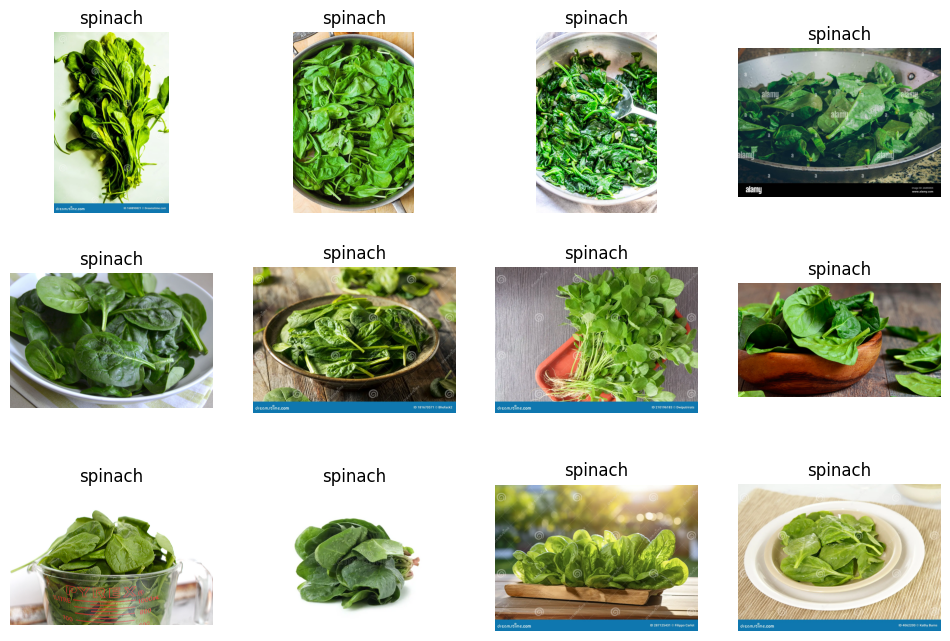

In [8]:
# Take 12 samples
samples = ds["train"].select(range(12))

plt.figure(figsize=(12, 8))
for i, sample in enumerate(samples):
    plt.subplot(3, 4, i + 1)
    plt.imshow(sample["image"])        # show image
    plt.axis("off")
    plt.title(sample["ingredient"])    # show ingredient name
plt.show()

In [9]:
preprocess_config = {
    "resize": 224,
    "center_crop": 224,
    "to_tensor": True,
    "normalize": True,
    "mean": (0.485, 0.456, 0.406),
    "std": (0.229, 0.224, 0.225),
    "augment_flip": True,
    "augment_color_jitter": False,
}

def build_preprocess_pipeline(cfg):
    transforms = []
    if cfg["resize"]:
        transforms.append(T.Resize(cfg["resize"], interpolation=T.InterpolationMode.BILINEAR))
    if cfg["center_crop"]:
        transforms.append(T.CenterCrop(cfg["center_crop"]))
    if cfg["augment_flip"]:
        transforms.append(T.RandomHorizontalFlip())
    if cfg["augment_color_jitter"]:
        transforms.append(T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2))
    if cfg["to_tensor"]:
        transforms.append(T.ToTensor())
    if cfg["normalize"]:
        transforms.append(T.Normalize(mean=cfg["mean"], std=cfg["std"]))
    return T.Compose(transforms)

# Build pipeline
preprocess_fn = build_preprocess_pipeline(preprocess_config)

In [10]:
def preprocess_batch(batch):
    # Apply transform to each image
    batch["pixel_values"] = [preprocess_fn(img.convert("RGB")) for img in batch["image"]]
    return batch

# 5. Apply preprocessing to dataset
ds_prepared = ds.with_transform(preprocess_batch)

# 6. Example: Access one processed sample
sample = ds_prepared["train"][0]
print(sample.keys())  # ['category', 'subcategory', 'ingredient', 'image', 'pixel_values']
print(sample["pixel_values"].shape)  # torch.Size([3, 224, 224])


dict_keys(['category', 'subcategory', 'ingredient', 'image', 'pixel_values'])
torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9306722..2.2317834].


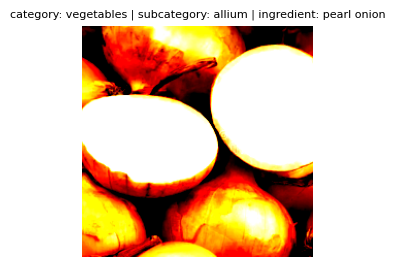

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].


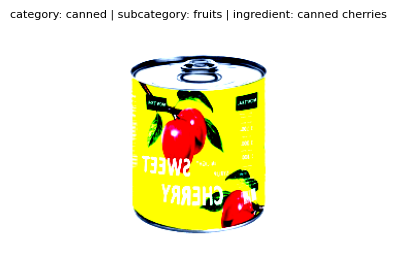

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


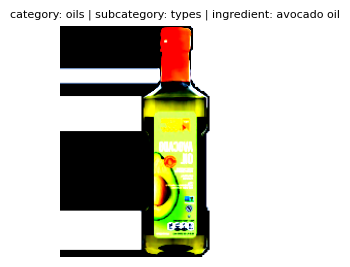

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.6051416].


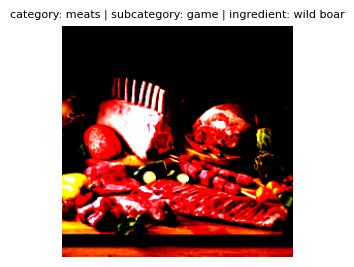

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0007002..2.5702832].


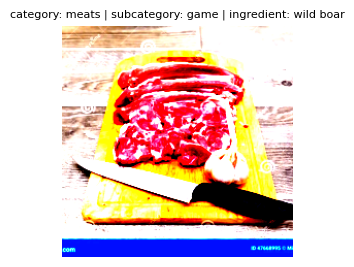

In [11]:
import torch

# Pick random samples from the training set
num_samples = 5  # change this to show more/less
indices = random.sample(range(len(ds_prepared["train"])), num_samples)

for i in indices:
    sample = ds_prepared["train"][i]
    img_tensor = sample["pixel_values"]

    # Convert tensor to displayable image
    img = img_tensor.permute(1, 2, 0).numpy()  # Convert from [C, H, W] to [H, W, C]

    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.axis("off")

    # Show some metadata (if available)
    title_parts = []
    for key in ["category", "subcategory", "ingredient"]:
        if key in sample:
            title_parts.append(f"{key}: {sample[key]}")
    plt.title(" | ".join(title_parts), fontsize=8)

    plt.show()


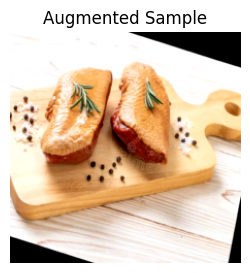

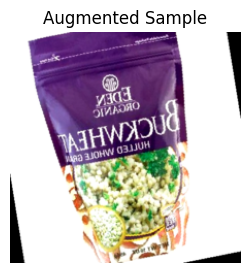

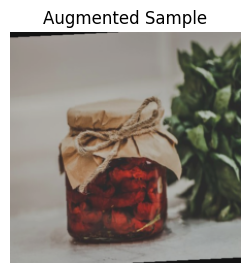

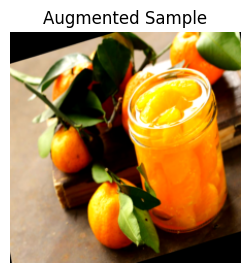

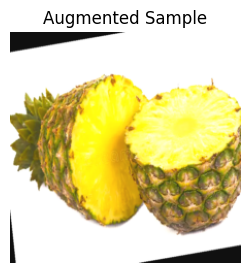

In [12]:
# Define an augmentation pipeline
augment_fn = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=15),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.RandomResizedCrop(224, scale=(0.8, 1.0)),
    T.ToTensor()
])

# Function to apply augmentation
def augment_batch(batch):
    batch["pixel_values"] = [augment_fn(img.convert("RGB")) for img in batch["image"]]
    return batch

# Apply augmentation to training dataset only
ds_augmented = ds["train"].with_transform(augment_batch)

for i in range(5):
    sample = ds_augmented[random.randint(0, len(ds_augmented)-1)]
    img = sample["pixel_values"].permute(1, 2, 0).numpy()
    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Augmented Sample")
    plt.show()

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import torch
torch.set_num_threads(4)  # Set to half your CPU cores
torch.cuda.empty_cache()
# 1️⃣ Custom Dataset wrapper
class IngredientDataset(Dataset):
    def __init__(self, hf_dataset):
        self.dataset = hf_dataset
        all_ingredients = list(set([example["ingredient"] for example in hf_dataset]))
        self.label2id = {label: i for i, label in enumerate(sorted(all_ingredients))}
        self.id2label = {i: label for label, i in self.label2id.items()}

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample["pixel_values"]
        label = self.label2id[sample["ingredient"]]
        return image, torch.tensor(label)

# 2️⃣ Create PyTorch datasets
train_dataset = IngredientDataset(ds_augmented)
val_dataset = IngredientDataset(ds_prepared["train"])  # using preprocessed (non-augmented) for validation

# 3️⃣ Dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# 4️⃣ Define Model — DenseNet121
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

# Replace classifier for 316 classes
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 316)
model = model.to(device)

# 5️⃣ Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 6️⃣ Training Loop — 10 epochs
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Validation phase
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%")

# 7️⃣ Save model
torch.save(model.state_dict(), "ingredient_classifier_densenet121.pth")
print("✅ Model training complete and saved as 'ingredient_classifier_densenet121.pth'")


C:\Users\abdul\AppData\Roaming\Python\Python312\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1/10: 100%|██████████| 418/418 [13:11<00:00,  1.89s/it]


Epoch [1/10], Loss: 5.0263
Validation Accuracy: 28.70%


Epoch 2/10: 100%|██████████| 418/418 [12:56<00:00,  1.86s/it]


Epoch [2/10], Loss: 3.5299
Validation Accuracy: 46.51%


Epoch 3/10: 100%|██████████| 418/418 [12:51<00:00,  1.85s/it]


Epoch [3/10], Loss: 2.6586
Validation Accuracy: 57.59%


Epoch 4/10: 100%|██████████| 418/418 [12:47<00:00,  1.84s/it]


Epoch [4/10], Loss: 2.0336
Validation Accuracy: 56.89%


Epoch 5/10: 100%|██████████| 418/418 [12:47<00:00,  1.84s/it]


Epoch [5/10], Loss: 1.5838
Validation Accuracy: 70.12%


Epoch 6/10: 100%|██████████| 418/418 [12:45<00:00,  1.83s/it]


Epoch [6/10], Loss: 1.2234
Validation Accuracy: 71.94%


Epoch 7/10: 100%|██████████| 418/418 [12:32<00:00,  1.80s/it]


Epoch [7/10], Loss: 0.9552
Validation Accuracy: 72.96%


Epoch 8/10: 100%|██████████| 418/418 [12:11<00:00,  1.75s/it]


Epoch [8/10], Loss: 0.7356
Validation Accuracy: 78.51%


Epoch 9/10: 100%|██████████| 418/418 [12:08<00:00,  1.74s/it]


Epoch [9/10], Loss: 0.5793
Validation Accuracy: 78.42%


Epoch 10/10: 100%|██████████| 418/418 [12:02<00:00,  1.73s/it]


Epoch [10/10], Loss: 0.4510
Validation Accuracy: 83.18%
✅ Model training complete and saved as 'ingredient_classifier_densenet121.pth'


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
from torch.utils.data import DataLoader # Make sure your train_loader and val_loader are available

# --- 1️⃣ SETUP AND LOAD SAVED MODEL ---

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the exact same model architecture
model = models.densenet121()
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 316)

# Load the weights you saved from the first 10 epochs
model_path = "ingredient_classifier_densenet121.pth"
model.load_state_dict(torch.load(model_path))
model.to(device)

print(f"✅ Model loaded from '{model_path}' and moved to {device}.")
print("Starting fine-tuning...")

# --- 2️⃣ FINE-TUNING SETUP ---

# Use a SMALLER learning rate to fine-tune the model
optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
num_epochs = 5  # We are training for 5 *more* epochs
start_epoch = 10 # Start counting from the previous run

# --- 3️⃣ CONTINUATION OF TRAINING LOOP ---

for epoch in range(num_epochs):
    current_epoch = start_epoch + epoch + 1
    model.train()
    running_loss = 0.0

    # Training phase
    for images, labels in tqdm(train_loader, desc=f"Epoch {current_epoch}/{start_epoch + num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{current_epoch}/{start_epoch + num_epochs}], Loss: {avg_loss:.4f}")

    # Validation phase
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%")

# --- 4️⃣ SAVE THE IMPROVED MODEL ---

# Save the fine-tuned model, overwriting the old one
torch.save(model.state_dict(), "ingredient_classifier_densenet121.pth")
print(f"✅ Fine-tuning complete. Updated model saved as '{model_path}'")

✅ Model loaded from 'ingredient_classifier_densenet121.pth' and moved to cuda.
Starting fine-tuning...


Epoch 11/15: 100%|██████████| 418/418 [12:32<00:00,  1.80s/it]


Epoch [11/15], Loss: 0.2915
Validation Accuracy: 86.31%


Epoch 12/15: 100%|██████████| 418/418 [13:20<00:00,  1.92s/it]


Epoch [12/15], Loss: 0.2426
Validation Accuracy: 86.56%


Epoch 13/15: 100%|██████████| 418/418 [12:29<00:00,  1.79s/it]


Epoch [13/15], Loss: 0.2244
Validation Accuracy: 88.00%


Epoch 14/15: 100%|██████████| 418/418 [12:30<00:00,  1.80s/it]


Epoch [14/15], Loss: 0.2143
Validation Accuracy: 89.41%


Epoch 15/15: 100%|██████████| 418/418 [12:27<00:00,  1.79s/it]


Epoch [15/15], Loss: 0.1964
Validation Accuracy: 88.54%
✅ Fine-tuning complete. Updated model saved as 'ingredient_classifier_densenet121.pth'
